I'm sending in this assignment 8 days after the deadline, and I'm using late days 1-8.

# Zvi Badash 214553034
## Assignment 15
### Question 1 - Implementing a Convolutional Layer
The video explaining the exercise can be found [here](https://youtu.be/X_hfCh3eUTM)

## Imports

In [236]:
import torch
from torchvision.transforms import ToTensor, Compose, Resize
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request

## Defining some useful util functions

In [237]:
def add_to_class(cls):
    def decorator(func):
        setattr(cls, func.__name__, func)
        return func
    return decorator

In [238]:
def sample_uniform(shape, a=0, b=1):
    """
    This function samples a tensor with shape `shape` from the uniform distribution U[a, b].
    :param shape: The shape of the tensor to sample.
    :param a: The lower bound.
    :param b: The upper bound.
    :return: The sampled tensor
    """
    return (b - a) * torch.rand(shape) + a

## Defining the layer

In [239]:
class MyConv2d(torch.nn.Module):
    """
    This layer is a 2D convolutional layer with multiple input channels and
    multiple output channels. The kernel is initialized randomly.

    The input is of shape (N, C_in, H, W) and the output is of shape
    (N, C_out, H_out, W_out) where H_out and W_out are computed as follows:
    H_out = (H + 2 * padding - p) // s + 1
    W_out = (W + 2 * padding - q) // s + 1
    where p and q are the height and width of the kernel and s is the stride.
    """

    def __init__(self, in_channels=1, out_channels=1, kernel_size=(3, 3), stride=1, padding=0):
        """

        :param in_channels:
        :param out_channels:
        :param kernel_size:
        :param stride:
        :param padding:
        """
        super().__init__()

        # Set up useful instance variables
        self.C_in = in_channels
        self.C_out = out_channels
        self.p, self.q = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize the kernel
        ## The kernel is drawn from the uniform distribution U[-√K, +√K]
        ## where K = 1 / (p * q * C_in)
        ## This initialization is directly from the PyTorch docs about the Conv2D layer.
        L = (self.p * self.q * self.C_in) ** (-0.5) # L = √K

        # The kernel shape suits both multiple in channels and multiple out channels.
        ## To make the convolution loop make sense later, we must remember that the current shape of the kernel is
        ## (C_out, C_in, p, q)
        kernel_shape = (self.C_out, self.C_in, *kernel_size)
        self.kernel = torch.nn.Parameter(
            sample_uniform(kernel_shape, a=-L, b=L)
        )

In [240]:
@add_to_class(MyConv2d)
def _pad(self, X):
    """
    This function pads X with `self.padding` zeroes around it in all directions, in the (H, W) dimensions.
    :param X: The input to pad.
    :return: The padded input.
    """
    # Get X's size
    N, _, H, W = X.size()

    # Create the padded tensor (leave the N, C_in dimensions as is, but add `2 * self.padding` to the (H, W) dimensions.
    X_padded = torch.zeros(N, self.C_in, H + 2 * self.padding, W + 2 * self.padding)

    # Copy X into the padded zeros' tensor, from `self.padding` to the `self.padding` from last indices in both (H, W) dimensions.
    padding_slice = slice(self.padding, -self.padding)
    X_padded[:, :, padding_slice, padding_slice] = X
    return X_padded

In [241]:
@add_to_class(MyConv2d)
def forward(self, X):
    """
    The forward pass of the convolutional layer.
    :param X: The input to the layer.
    :return: The output of the layer.
    """
    # Pad the input if needed
    if self.padding > 0:
        X = self._pad(X)

    # Get X's size
    N, _, H, W = X.size()

    # Compute the output size
    new_H = (H - self.p) // self.stride + 1
    new_W = (W - self.q) // self.stride + 1

    # Create the empty (for now) output tensor
    outputs = torch.empty(N, self.C_out, new_H, new_W)

    # Calculate the convolution
    for i in range(new_H):
        for j in range(new_W):
            # Take a slice of X (remembering stride) so that we can later multiply it by the kernel.
            H_slice = slice(i * self.stride, i * self.stride + self.p)
            W_slice = slice(j * self.stride, j * self.stride + self.q)
            sub_images = X[:, :, H_slice, W_slice]

            # Right now, sub_images is of shape (N, C_in, p, q) and the kernel is of shape (C_out, C_in, p, q).
            ## So, we need to add a dimension to sub_images so that we can multiply it by the kernel.
            sub_images = sub_images.unsqueeze(1)

            # Now, sub_images is of shape (N, 1, C_in, p, q) and the kernel is of shape (C_out, C_in, p, q).
            ## Torch will automatically broadcast the 1 dimension to the C_out dimension, so we can multiply them.
            ## The summation is done over the C_in, p, q dimensions, leaving us with a tensor of shape (N, C_out).
            outputs[:, :, i, j] = (sub_images * self.kernel).sum(dim=(2, 3, 4))

    # Return the output, of shape (N, C_out, new_H, new_W)
    return outputs

## Testing the layer on a mock image

### Creating the image

In [242]:
urllib.request.urlretrieve("https://t0.gstatic.com/licensed-image?q=tbn:ANd9GcQCO_npH_53Ye8CzS0mYFLZValxK5r_58Z5_PKml_HJ49pvbZEKzzuTuExBsp4ICc18", "horse.jpg")

('horse.jpg', <http.client.HTTPMessage at 0x1a1fe329150>)

In [243]:
image = Image.open("horse.jpg")

In [244]:
image = Compose([
    Resize(300, antialias=True),
    ToTensor()
])(image)

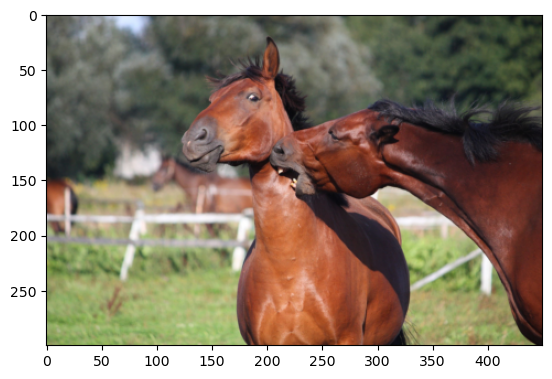

In [245]:
plt.imshow(image.permute(1, 2, 0))

### Creating the layers

In [246]:
out_channels = 6

In [247]:
rows = 3
channels_per_row = out_channels // rows

In [248]:
my_layer = MyConv2d(
    in_channels=3,
    out_channels=out_channels,
    kernel_size=(3, 3),
    stride=2,
    padding=4
)

In [249]:
torch_layer = torch.nn.Conv2d(
    bias=False,
    in_channels=3,
    out_channels=out_channels,
    kernel_size=(3, 3),
    stride=2,
    padding=4
)

## Testing both layers with the same kernel

In [250]:
kernel = torch.randn_like(my_layer.kernel)

In [251]:
my_layer.kernel.requires_grad = False
my_layer.kernel = torch.nn.Parameter(kernel)

In [252]:
torch_layer.weight.requires_grad = False
torch_layer.weight = torch.nn.Parameter(kernel)

In [253]:
my_conv = my_layer(image.unsqueeze(0)).squeeze(0)
torch_conv = torch_layer(image.unsqueeze(0)).squeeze(0)

In [254]:
assert my_conv.size() == torch_conv.size()

In [255]:
assert torch.allclose(my_conv, torch_conv, atol=1e-5)

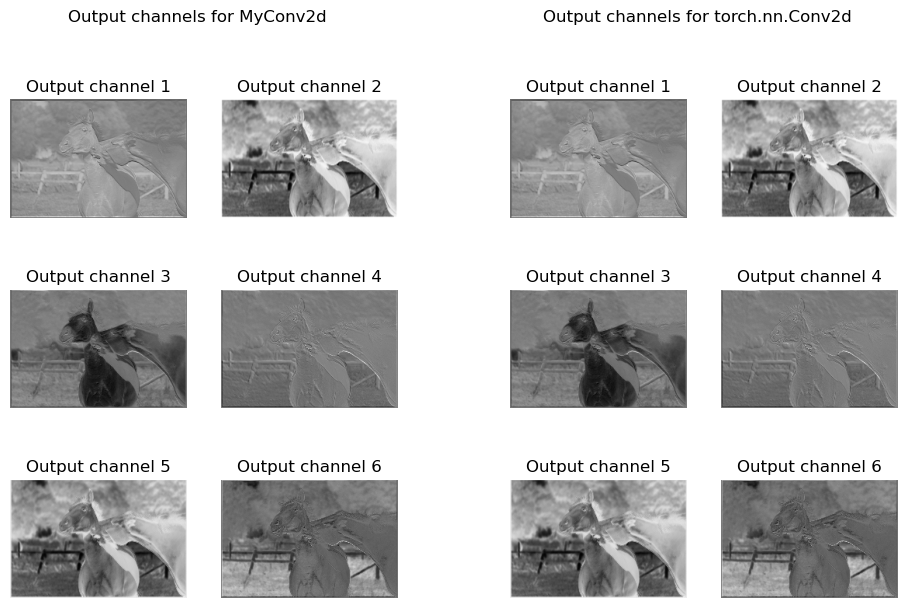

In [256]:
# Set two sub-figures for the two layers
fig = plt.figure(figsize=(10, 7))
subfigs = fig.subfigures(1, 2)

# For each sub-figure, create a 2x2 grid of axes
for i, subfig in enumerate(subfigs):
    axes = subfig.subplots(rows, channels_per_row)
    subfig.suptitle(f"Output channels for {['MyConv2d', 'torch.nn.Conv2d'][i]}")

    # For each axis, plot the corresponding output channel
    for j, ax in enumerate(axes.flatten()):
        conv = [my_conv, torch_conv][i]
        ax.imshow(conv[j].detach().numpy(), cmap="gray")
        ax.set_title(f"Output channel {j + 1}")
        ax.axis("off")